In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import datetime
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

from dask.diagnostics import ProgressBar
ProgressBar().register()

MERRA-2 and ERA5 only unique interpolated locations

In [2]:
# open turbine files
wt_mer_gwa = pd.read_csv('/data/users/kgruber/other-data/USA/turbine_data_mer_gwa.csv', index_col=0)
wt_mer = pd.read_csv('/data/users/kgruber/other-data/USA/turbine_data_mer.csv', index_col=0)
wt_era_gwa = pd.read_csv('/data/users/kgruber/other-data/USA/turbine_data_era_gwa.csv', index_col=0)
wt_era = pd.read_csv('/data/users/kgruber/other-data/USA/turbine_data_era.csv', index_col=0)

In [3]:
# open wind files
wind_mer = xr.open_mfdataset("/data/users/kgruber/Data/MERRA/USA/eff_ws/merra2_wind_USA_*.nc", chunks = {'time': 38})
alpha_mer = xr.open_mfdataset("/data/users/kgruber/Data/MERRA/USA/eff_ws/merra2_alpha_USA_*.nc", chunks = {'time': 38})
wind_era = xr.open_mfdataset("/data/users/kgruber/Data/era5/USA/eff_ws/era5_wind_USA_*.nc", chunks = {'time': 38})
alpha_era = xr.open_mfdataset("/data/users/kgruber/Data/era5/USA/eff_ws/era5_alpha_USA_*.nc", chunks = {'time': 38})

In [4]:
# Create dataframe with sequence the size of MERRA-2 grid to find out which turbines interpolate to the same point
in_seq_mer = xr.Dataset({'x':(['lat','lon'],
                              np.array(range(wind_mer.wh50.isel(time=0).values.size)).reshape(wind_mer.wh50.isel(time=0).values.shape))},
                         coords = {'lat':wind_mer.lat.values,
                                   'lon':wind_mer.lon.values})
in_seq_era = xr.Dataset({'x':(['lat','lon'],
                              np.array(range(wind_era.wh100.isel(time=0).values.size)).reshape(wind_era.wh100.isel(time=0).values.shape))},
                         coords = {'lat':wind_era.latitude.values,
                                   'lon':wind_era.longitude.values})

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [5]:
# interpolate to reanalysis grid points
ip_mer_gwa = in_seq_mer.interp(coords={"lon":xr.DataArray(wt_mer_gwa.lon,dims='location'),
                                       "lat":xr.DataArray(wt_mer_gwa.lat,dims='location')},method="nearest").to_dataframe()
ip_mer = in_seq_mer.interp(coords={"lon":xr.DataArray(wt_mer.lon,dims='location'),
                                   "lat":xr.DataArray(wt_mer.lat,dims='location')},method="nearest").to_dataframe()
ip_era_gwa = in_seq_era.interp(coords={"lon":xr.DataArray(wt_era_gwa.lon,dims='location'),
                                       "lat":xr.DataArray(wt_era_gwa.lat,dims='location')},method="nearest").to_dataframe()
ip_era = in_seq_era.interp(coords={"lon":xr.DataArray(wt_era.lon,dims='location'),
                                   "lat":xr.DataArray(wt_era.lat,dims='location')},method="nearest").to_dataframe()

In [6]:
# find unique locations
uniques_mer = ip_mer.groupby(ip_mer.x).min()
uniques_era = ip_era.groupby(ip_era.x).min()

In [7]:
# add ids to unique correlation locations
uniques_era['cor_id'] = range(len(uniques_era.index))
uniques_mer['cor_id'] = range(len(uniques_mer.index))

In [8]:
# add correlation ids to wind turbine data
wt_mer['cor_id'] = ip_mer.x.map(uniques_mer.cor_id)
wt_mer_gwa['cor_id'] = ip_mer_gwa.x.map(uniques_mer.cor_id)
wt_era['cor_id'] = ip_era.x.map(uniques_era.cor_id)
wt_era_gwa['cor_id'] = ip_era_gwa.x.map(uniques_era.cor_id)

In [138]:
# interpolate wind to unique locations and extrapolate to 80 m hubheight, which is mean hubheight in US
windi_mer = wind_mer.interp(coords={"lon":xr.DataArray(uniques_mer.lon,dims='location'),
                                    "lat":xr.DataArray(uniques_mer.lat,dims='location')},method="nearest")
windi_era = wind_era.interp(coords={"longitude":xr.DataArray(uniques_era.lon,dims='location'),
                                    "latitude":xr.DataArray(uniques_era.lat,dims='location')},method="nearest")

In [139]:
alphai_mer = alpha_mer.interp(coords={"lon":xr.DataArray(uniques_mer.lon,dims='location'),
                                      "lat":xr.DataArray(uniques_mer.lat,dims='location')},method="nearest")
alphai_era = alpha_era.interp(coords={"longitude":xr.DataArray(uniques_era.lon,dims='location'),
                                      "latitude":xr.DataArray(uniques_era.lat,dims='location')},method="nearest")

In [140]:
windhh_mer = (windi_mer.wh50 * (80/50)**alphai_mer.alpha)
windhh_era = (windi_era.wh100 * (80/100)**alphai_era.alpha)

In [ ]:
c_mer = np.corrcoef(windhh_mer,rowvar=False)

In [24]:
xr.DataArray(c_mer,
             dims = ['id1','id2'],
             coords = {'id1':range(c_mer.shape[0]),
                       'id2':range(c_mer.shape[0])}).to_netcdf('/data/users/kgruber/results/USA/results_GWA2/corr_mer.nc')

In [25]:
c_era = np.corrcoef(windhh_era,rowvar=False)

[########################################] | 100% Completed |  6min 25.7s


In [26]:
xr.DataArray(c_era,
             dims = ['id1','id2'],
             coords = {'id1':range(c_era.shape[0]),
                       'id2':range(c_era.shape[0])}).to_netcdf('/data/users/kgruber/results/USA/results_GWA2/corr_era.nc')

# Load data

In [9]:
c_mer = xr.open_dataarray('/data/users/kgruber/results/USA/results_GWA2/corr_mer.nc').values
c_era = xr.open_dataarray('/data/users/kgruber/results/USA/results_GWA2/corr_era.nc').values

### Do for a region - start with TX

In [10]:
wt_mer_TX = wt_mer[wt_mer.state=='TX']
wt_mer_gwa_TX = wt_mer_gwa[wt_mer_gwa.state=='TX']
wt_era_TX = wt_era[wt_era.state=='TX']
wt_era_gwa_TX = wt_era_gwa[wt_era_gwa.state=='TX']

[########################################] | 100% Completed |  2min 55.5s
[########################################] | 100% Completed | 32.5s


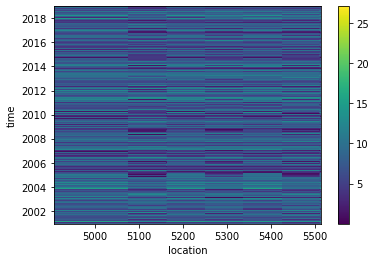

In [23]:
windhh_mer.isel(location=wt_mer_TX.cor_id.unique()[:10]).plot()

In [96]:
windhh_mer.isel(location=wt_mer_TX.cor_id.unique()[:10]).var('time').values

[########################################] | 100% Completed | 57.8s


array([8.224147 , 8.7272215, 8.1095295, 7.6235514, 8.176281 , 7.855643 ,
       8.124128 , 8.19459  , 7.758245 , 7.8873525], dtype=float32)

In [11]:
# non unique values
c_TX_merNU = np.array([list(c_mer[wt_mer_TX.cor_id.values[i],
                                  np.delete(wt_mer_TX.cor_id.values,i,0)]) for i in range(len(wt_mer_TX.cor_id))])
c_TX_mer_gwaNU = np.array([list(c_mer[wt_mer_gwa_TX.cor_id.values[i],
                                      np.delete(wt_mer_gwa_TX.cor_id.values,i,0)]) for i in range(len(wt_mer_gwa_TX.cor_id))])
c_TX_eraNU = np.array([list(c_era[wt_era_TX.cor_id.values[i],
                                  np.delete(wt_era_TX.cor_id.values,i,0)]) for i in range(len(wt_era_TX.cor_id))])
c_TX_era_gwaNU = np.array([list(c_era[wt_era_gwa_TX.cor_id.values[i],
                                      np.delete(wt_era_gwa_TX.cor_id.values,i,0)]) for i in range(len(wt_era_gwa_TX.cor_id))])

In [12]:
# unique values
c_TX_mer = np.array([list(c_mer[wt_mer_TX.cor_id.unique()[i],
                                np.delete(wt_mer_TX.cor_id.unique(),i,0)]) for i in range(len(wt_mer_TX.cor_id.unique()))])
c_TX_mer_gwa = np.array([list(c_mer[wt_mer_gwa_TX.cor_id.unique()[i],
                                    np.delete(wt_mer_gwa_TX.cor_id.unique(),i,0)]) for i in range(len(wt_mer_gwa_TX.cor_id.unique()))])
c_TX_era = np.array([list(c_era[wt_era_TX.cor_id.unique()[i],
                                np.delete(wt_era_TX.cor_id.unique(),i,0)]) for i in range(len(wt_era_TX.cor_id.unique()))])
c_TX_era_gwa = np.array([list(c_era[wt_era_gwa_TX.cor_id.unique()[i],
                                    np.delete(wt_era_gwa_TX.cor_id.unique(),i,0)]) for i in range(len(wt_era_gwa_TX.cor_id.unique()))])

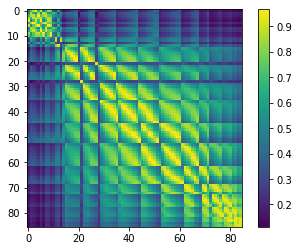

In [228]:
plt.imshow(c_TX_mer)
plt.colorbar()

In [231]:
c_TX_merNU.mean()

0.5748996562644375

In [229]:
c_TX_mer.mean()

0.5371951943853581

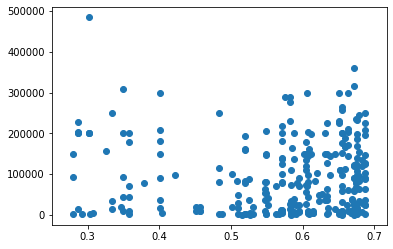

In [233]:
plt.scatter(c_TX_merNU.mean(axis=1),wt_mer_TX.capacity.values)

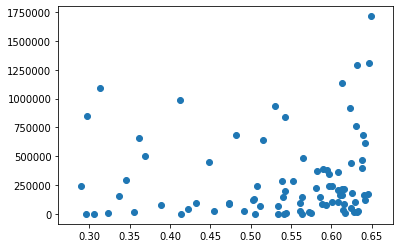

In [236]:
plt.scatter(c_TX_mer.mean(axis=1),wt_mer_TX.capacity.groupby(wt_mer_TX.cor_id).sum().values)

In [53]:
# weighted by capacity
c_TX_wc = np.array([list(c_mer[wt_mer_TX.cor_id.values[i],np.delete(wt_mer_TX.cor_id.values,i,0)]*wt_mer_TX.capacity.values[i]) for i in range(len(wt_mer_TX.cor_id))])

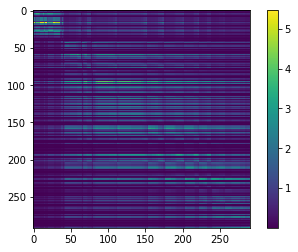

In [92]:
plt.imshow(c_TX_wc/wt_mer_TX.capacity.values.mean())
plt.colorbar()

In [86]:
(c_TX_wc/wt_mer_TX.capacity.values.mean()).mean()

0.5688939771450681

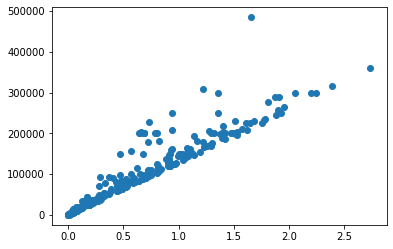

In [87]:
plt.scatter((c_TX_wc/wt_mer_TX.capacity.values.mean()).mean(axis=1),wt_mer_TX.capacity.values)

In [64]:
(c_TX_wc/wt_mer_TX.capacity.values.mean()).mean()

0.5688939771450681

In [144]:
# wighted and normalised by capacity
c_TX_norm = (wt_mer_TX.capacity.values*(c_TX.transpose()+1))/(wt_mer_TX.capacity.values.mean())-1

In [147]:
c_TX_norm.mean()

0.568893977145068

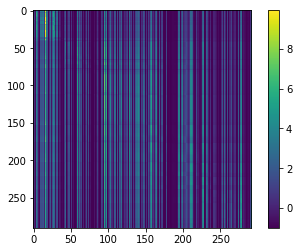

In [148]:
plt.imshow(c_TX_norm)
plt.colorbar()

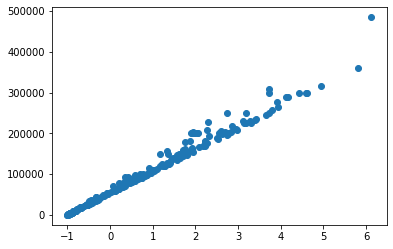

In [150]:
plt.scatter(c_TX_norm.mean(axis=0),wt_mer_TX.capacity.values)

(array([128.,  36.,  31.,  35.,  25.,  18.,  11.,   5.,   1.,   2.]),
 array([-0.99829283, -0.28690611,  0.42448061,  1.13586732,  1.84725404,
         2.55864076,  3.27002748,  3.98141419,  4.69280091,  5.40418763,
         6.11557434]),
 <a list of 10 Patch objects>)

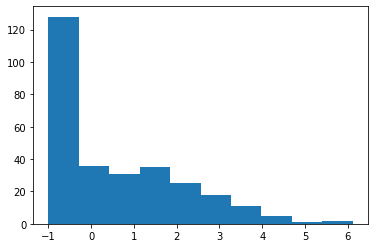

In [151]:
plt.hist(c_TX_norm.mean(axis=0))

In [13]:
# unique values
mc_TX_mer = np.array([list(c_mer[wt_mer_TX.cor_id.unique()[i],
                                np.delete(wt_mer_TX.cor_id.unique(),i,0)]) for i in range(len(wt_mer_TX.cor_id.unique()))]).mean()
mc_TX_mer_gwa = np.array([list(c_mer[wt_mer_gwa_TX.cor_id.unique()[i],
                                    np.delete(wt_mer_gwa_TX.cor_id.unique(),i,0)]) for i in range(len(wt_mer_gwa_TX.cor_id.unique()))]).mean()
mc_TX_era = np.array([list(c_era[wt_era_TX.cor_id.unique()[i],
                                np.delete(wt_era_TX.cor_id.unique(),i,0)]) for i in range(len(wt_era_TX.cor_id.unique()))]).mean()
mc_TX_era_gwa = np.array([list(c_era[wt_era_gwa_TX.cor_id.unique()[i],
                                    np.delete(wt_era_gwa_TX.cor_id.unique(),i,0)]) for i in range(len(wt_era_gwa_TX.cor_id.unique()))]).mean()

### BPA

In [14]:
# get BPA windparks
BPA_parks = pd.read_csv("/data/users/kgruber/other-data/USA/BPA_windparks.csv")
# get windturbine locations/names
windturbines = pd.read_csv("/data/users/kgruber/other-data/USA/windturbines_usa.csv",delimiter=';')
# get labels
labels = pd.read_csv('/data/users/kgruber/other-data/USA/labels_turbine_data.csv')
# get indices of BPA wind parks from wind turbine dataset
pBPA = pd.DataFrame({'p': [park in BPA_parks.name.values for park in windturbines[windturbines.t_state!='GU'].p_name.values]})

In [15]:
# remove turbines that are in other states - error in data?
pBPA[windturbines[windturbines.t_state!='GU'].xlong.values<-125] = False
pBPA[windturbines[windturbines.t_state!='GU'].xlong.values>-115] = False

In [16]:
BPA_mer = pBPA.groupby(labels.lbl_mer).mean() # get shares of where BPA wind parks are installed
BPA_mer_gwa = pBPA.groupby(labels.lbl_mer_gwa).mean()
BPA_era = pBPA.groupby(labels.lbl_era).mean()
BPA_era_gwa = pBPA.groupby(labels.lbl_era_gwa).mean()

In [17]:
BPA_mer['cor_id'] = wt_mer.cor_id.values
BPA_mer_gwa['cor_id'] = wt_mer_gwa.cor_id.values
BPA_era['cor_id'] = wt_era.cor_id.values
BPA_era_gwa['cor_id'] = wt_era_gwa.cor_id.values

In [18]:
BPA_mer = BPA_mer[BPA_mer.p>0]
BPA_mer_gwa = BPA_mer_gwa[BPA_mer_gwa.p>0]
BPA_era = BPA_era[BPA_era.p>0]
BPA_era_gwa = BPA_era_gwa[BPA_era_gwa.p>0]

In [19]:
mc_BPA_mer = np.array([list(c_mer[BPA_mer.cor_id.unique()[i],
                                 np.delete(BPA_mer.cor_id.unique(),i,0)]) for i in range(len(BPA_mer.cor_id.unique()))]).mean()
mc_BPA_mer_gwa = np.array([list(c_mer[BPA_mer_gwa.cor_id.unique()[i],
                                     np.delete(BPA_mer_gwa.cor_id.unique(),i,0)]) for i in range(len(BPA_mer_gwa.cor_id.unique()))]).mean()
mc_BPA_era = np.array([list(c_era[BPA_era.cor_id.unique()[i],
                                 np.delete(BPA_era.cor_id.unique(),i,0)]) for i in range(len(BPA_era.cor_id.unique()))]).mean()
mc_BPA_era_gwa = np.array([list(c_era[BPA_era_gwa.cor_id.unique()[i],
                                         np.delete(BPA_era_gwa.cor_id.unique(),i,0)]) for i in range(len(BPA_era_gwa.cor_id.unique()))]).mean()

In [41]:
mc_BPA_mer

0.6331066095613402

In [237]:
mc_BPA_mer # old version with wring wind parks

0.36666428233167647

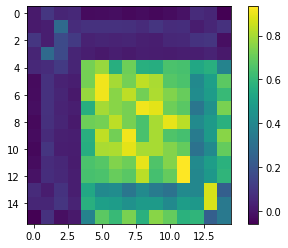

In [242]:
plt.imshow(np.array([list(c_mer[BPA_mer.cor_id.unique()[i],
                                 np.delete(BPA_mer.cor_id.unique(),i,0)]) for i in range(len(BPA_mer.cor_id.unique()))]))
plt.colorbar() # old version with wring wind parks

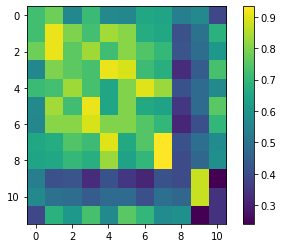

In [42]:
plt.imshow(np.array([list(c_mer[BPA_mer.cor_id.unique()[i],
                                 np.delete(BPA_mer.cor_id.unique(),i,0)]) for i in range(len(BPA_mer.cor_id.unique()))]))
plt.colorbar()

In [238]:
mc_BPA_mer_2017

0.6513433018371698

[########################################] | 100% Completed |  0.1s


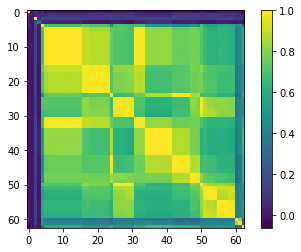

In [241]:
plt.imshow(c_mer_2017_BPA)
plt.colorbar()

### IA

In [20]:
wt_mer_IA = wt_mer[wt_mer.state=='IA']
wt_mer_gwa_IA = wt_mer_gwa[wt_mer_gwa.state=='IA']
wt_era_IA = wt_era[wt_era.state=='IA']
wt_era_gwa_IA = wt_era_gwa[wt_era_gwa.state=='IA']

In [21]:
mc_IA_mer = np.array([list(c_mer[wt_mer_IA.cor_id.unique()[i],
                                np.delete(wt_mer_IA.cor_id.unique(),i,0)]) for i in range(len(wt_mer_IA.cor_id.unique()))]).mean()
mc_IA_mer_gwa = np.array([list(c_mer[wt_mer_gwa_IA.cor_id.unique()[i],
                                    np.delete(wt_mer_gwa_IA.cor_id.unique(),i,0)]) for i in range(len(wt_mer_gwa_IA.cor_id.unique()))]).mean()
mc_IA_era = np.array([list(c_era[wt_era_IA.cor_id.unique()[i],
                                np.delete(wt_era_IA.cor_id.unique(),i,0)]) for i in range(len(wt_era_IA.cor_id.unique()))]).mean()
mc_IA_era_gwa = np.array([list(c_era[wt_era_gwa_IA.cor_id.unique()[i],
                                    np.delete(wt_era_gwa_IA.cor_id.unique(),i,0)]) for i in range(len(wt_era_gwa_IA.cor_id.unique()))]).mean()

### New England

In [22]:
NE_states = ['CT','NH','ME','MA','RI','VT']

In [23]:
wt_mer_NE = wt_mer[[state in NE_states for state in wt_mer.state]]
wt_mer_gwa_NE = wt_mer_gwa[[state in NE_states for state in wt_mer_gwa.state]]
wt_era_NE = wt_era[[state in NE_states for state in wt_era.state]]
wt_era_gwa_NE = wt_era_gwa[[state in NE_states for state in wt_era_gwa.state]]

In [24]:
mc_NE_mer = np.array([list(c_mer[wt_mer_NE.cor_id.unique()[i],
                                np.delete(wt_mer_NE.cor_id.unique(),i,0)]) for i in range(len(wt_mer_NE.cor_id.unique()))]).mean()
mc_NE_mer_gwa = np.array([list(c_mer[wt_mer_gwa_NE.cor_id.unique()[i],
                                    np.delete(wt_mer_gwa_NE.cor_id.unique(),i,0)]) for i in range(len(wt_mer_gwa_NE.cor_id.unique()))]).mean()
mc_NE_era = np.array([list(c_era[wt_era_NE.cor_id.unique()[i],
                                np.delete(wt_era_NE.cor_id.unique(),i,0)]) for i in range(len(wt_era_NE.cor_id.unique()))]).mean()
mc_NE_era_gwa = np.array([list(c_era[wt_era_gwa_NE.cor_id.unique()[i],
                                    np.delete(wt_era_gwa_NE.cor_id.unique(),i,0)]) for i in range(len(wt_era_gwa_NE.cor_id.unique()))]).mean()

### USA

In [25]:
mc_USA_mer = np.array([list(c_mer[wt_mer.cor_id.unique()[i],
                                np.delete(wt_mer.cor_id.unique(),i,0)]) for i in range(len(wt_mer.cor_id.unique()))]).mean()
mc_USA_mer_gwa = np.array([list(c_mer[wt_mer_gwa.cor_id.unique()[i],
                                    np.delete(wt_mer_gwa.cor_id.unique(),i,0)]) for i in range(len(wt_mer_gwa.cor_id.unique()))]).mean()
mc_USA_era = np.array([list(c_era[wt_era.cor_id.unique()[i],
                                np.delete(wt_era.cor_id.unique(),i,0)]) for i in range(len(wt_era.cor_id.unique()))]).mean()
mc_USA_era_gwa = np.array([list(c_era[wt_era_gwa.cor_id.unique()[i],
                                    np.delete(wt_era_gwa.cor_id.unique(),i,0)]) for i in range(len(wt_era_gwa.cor_id.unique()))]).mean()

#### plot mean correlations agains physical size (km^2)

In [269]:
sizes_cors = pd.DataFrame({'cor_mer':[c_IA_mer.mean(),c_NE_mer.mean(),c_TX_mer.mean(),c_USA_mer.mean()],
                           'cor_era':[c_IA_era.mean(),c_NE_era.mean(),c_TX_era.mean(),c_USA_era.mean()],
                           'size_km2':[145743,186458,695662,9834000]},index=['IA','NE','TX','USA'])

Text(0, 0.5, 'mean(cor)')

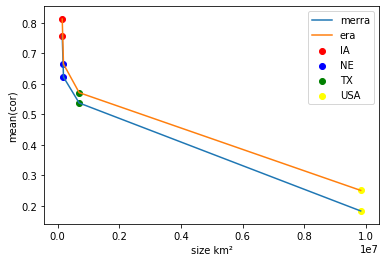

In [279]:
plt.plot(sizes_cors.size_km2.values,sizes_cors.cor_mer.values,label='merra')
plt.plot(sizes_cors.size_km2.values,sizes_cors.cor_era.values,label='era')
plt.scatter([sizes_cors.size_km2.values[0],sizes_cors.size_km2.values[0]],
            [sizes_cors.cor_mer.values[0],sizes_cors.cor_era.values[0]],color='red',label=sizes_cors.index.values[0])
plt.scatter([sizes_cors.size_km2.values[1],sizes_cors.size_km2.values[1]],
            [sizes_cors.cor_mer.values[1],sizes_cors.cor_era.values[1]],color='blue',label=sizes_cors.index.values[1])
plt.scatter([sizes_cors.size_km2.values[2],sizes_cors.size_km2.values[2]],
            [sizes_cors.cor_mer.values[2],sizes_cors.cor_era.values[2]],color='green',label=sizes_cors.index.values[2])
plt.scatter([sizes_cors.size_km2.values[3],sizes_cors.size_km2.values[3]],
            [sizes_cors.cor_mer.values[3],sizes_cors.cor_era.values[3]],color='yellow',label=sizes_cors.index.values[3])

plt.legend()
plt.xlabel('size km²')
plt.ylabel('mean(cor)')

In [287]:
mean_cors_18y_wind = pd.DataFrame({'cor_mer':[c_BPA_mer.mean(),c_IA_mer.mean(),c_NE_mer.mean(),c_TX_mer.mean(),c_USA_mer.mean()],
                                   'cor_era':[c_BPA_mer.mean(),c_IA_era.mean(),c_NE_era.mean(),c_TX_era.mean(),c_USA_era.mean()]},
                                  index = ['BPA','IA','NE','TX','USA'])

In [288]:
mean_cors_18y_wind.to_csv('/data/users/kgruber/results/USA/correlations_wind_18y.csv')

## Compare to windpower correlations

### USA

2018

In [26]:
c_mer_2018 = xr.open_dataset('/data/users/kgruber/results/USA/results_GWA2/cor_mer_2018.nc',chunks = {'dim_0':1000})
c_mer_gwa_2018 = xr.open_dataset('/data/users/kgruber/results/USA/results_GWA2/cor_mer_gwa_2018.nc',chunks = {'dim_0':1000})
c_era_2018 = xr.open_dataset('/data/users/kgruber/results/USA/results_GWA2/cor_era_2018.nc',chunks = {'dim_0':1000})
c_era_gwa_2018 = xr.open_dataset('/data/users/kgruber/results/USA/results_GWA2/cor_era_gwa_2018.nc',chunks = {'dim_0':1000})

In [27]:
mc_USA_mer_2018 = float((c_mer_2018.c.sum()-c_mer_2018.c.shape[0])/(c_mer_2018.c.size-c_mer_2018.c.shape[0]))
mc_USA_mer_gwa_2018 = float((c_mer_gwa_2018.c.sum()-c_mer_gwa_2018.c.shape[0])/(c_mer_gwa_2018.c.size-c_mer_gwa_2018.c.shape[0]))
mc_USA_era_2018 = float((c_era_2018.c.sum()-c_era_2018.c.shape[0])/(c_era_2018.c.size-c_era_2018.c.shape[0]))
mc_USA_era_gwa_2018 = float((c_era_gwa_2018.c.sum()-c_era_gwa_2018.c.shape[0])/(c_era_gwa_2018.c.size-c_era_gwa_2018.c.shape[0]))

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed | 52.0s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed | 57.0s


2017

In [28]:
c_mer_2017 = xr.open_dataset('/data/users/kgruber/results/USA/results_GWA2/cor_mer_2017.nc',chunks = {'dim_0':1000})
c_mer_gwa_2017 = xr.open_dataset('/data/users/kgruber/results/USA/results_GWA2/cor_mer_gwa_2017.nc',chunks = {'dim_0':1000})
c_era_2017 = xr.open_dataset('/data/users/kgruber/results/USA/results_GWA2/cor_era_2017.nc',chunks = {'dim_0':1000})
c_era_gwa_2017 = xr.open_dataset('/data/users/kgruber/results/USA/results_GWA2/cor_era_gwa_2017.nc',chunks = {'dim_0':1000})

In [29]:
mc_USA_mer_2017 = float((c_mer_2017.c.sum()-c_mer_2017.c.shape[0])/(c_mer_2017.c.size-c_mer_2017.c.shape[0]))
mc_USA_mer_gwa_2017 = float((c_mer_gwa_2017.c.sum()-c_mer_gwa_2017.c.shape[0])/(c_mer_gwa_2017.c.size-c_mer_gwa_2017.c.shape[0]))
mc_USA_era_2017 = float((c_era_2017.c.sum()-c_era_2017.c.shape[0])/(c_era_2017.c.size-c_era_2017.c.shape[0]))
mc_USA_era_gwa_2017 = float((c_era_gwa_2017.c.sum()-c_era_gwa_2017.c.shape[0])/(c_era_gwa_2017.c.size-c_era_gwa_2017.c.shape[0]))

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  1min  9.7s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  1min  2.3s


2017 + 2018

In [30]:
c_mer_201718 = xr.open_dataset('/data/users/kgruber/results/USA/results_GWA2/cor_mer_2017-2018.nc',chunks = {'dim_0':1000})
c_era_201718 = xr.open_dataset('/data/users/kgruber/results/USA/results_GWA2/cor_era_2017-2018.nc',chunks = {'dim_0':1000})

In [31]:
mc_USA_mer_201718 = float((c_mer_201718.c.sum()-c_mer_201718.c.shape[0])/(c_mer_201718.c.size-c_mer_201718.c.shape[0]))
mc_USA_era_201718 = float((c_era_201718.c.sum()-c_era_201718.c.shape[0])/(c_era_201718.c.size-c_era_201718.c.shape[0]))

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s


### TX

In [32]:
ind_TX_mer = np.where(wt_mer.state=='TX')[0]
ind_TX_mer_gwa = np.where(wt_mer_gwa.state=='TX')[0]
ind_TX_era = np.where(wt_era.state=='TX')[0]
ind_TX_era_gwa = np.where(wt_era_gwa.state=='TX')[0]

2017

In [33]:
mc_TX_mer_2017 = float((c_mer_2017.c[ind_TX_mer,ind_TX_mer].sum()-len(ind_TX_mer))/(len(ind_TX_mer)**2-len(ind_TX_mer)))
mc_TX_mer_gwa_2017 = float((c_mer_gwa_2017.c[ind_TX_mer_gwa,ind_TX_mer_gwa].sum()-len(ind_TX_mer_gwa))/(len(ind_TX_mer_gwa)**2-len(ind_TX_mer_gwa)))
mc_TX_era_2017 = float((c_era_2017.c[ind_TX_era,ind_TX_era].sum()-len(ind_TX_era))/(len(ind_TX_era)**2-len(ind_TX_era)))
mc_TX_era_gwa_2017 = float((c_era_gwa_2017.c[ind_TX_era_gwa,ind_TX_era_gwa].sum()-len(ind_TX_era_gwa))/(len(ind_TX_era_gwa)**2-len(ind_TX_era_gwa)))

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  2.5s


2018

In [42]:
mc_TX_mer_2018 = float((c_mer_2018.c[ind_TX_mer,ind_TX_mer].sum()-len(ind_TX_mer))/(len(ind_TX_mer)**2-len(ind_TX_mer)))
mc_TX_mer_gwa_2018 = float((c_mer_gwa_2018.c[ind_TX_mer_gwa,ind_TX_mer_gwa].sum()-len(ind_TX_mer_gwa))/(len(ind_TX_mer_gwa)**2-len(ind_TX_mer_gwa)))
mc_TX_era_2018 = float((c_era_2018.c[ind_TX_era,ind_TX_era].sum()-len(ind_TX_era))/(len(ind_TX_era)**2-len(ind_TX_era)))
mc_TX_era_gwa_2018 = float((c_era_gwa_2018.c[ind_TX_era_gwa,ind_TX_era_gwa].sum()-len(ind_TX_era_gwa))/(len(ind_TX_era_gwa)**2-len(ind_TX_era_gwa)))

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed | 17.8s


2017-2018

In [43]:
mc_TX_mer_201718 = float((c_mer_201718.c[ind_TX_mer,ind_TX_mer].sum()-len(ind_TX_mer))/(len(ind_TX_mer)**2-len(ind_TX_mer)))
mc_TX_era_201718 = float((c_era_201718.c[ind_TX_era,ind_TX_era].sum()-len(ind_TX_era))/(len(ind_TX_era)**2-len(ind_TX_era)))

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


### IA

In [44]:
ind_IA_mer = np.where(wt_mer.state=='IA')[0]
ind_IA_mer_gwa = np.where(wt_mer_gwa.state=='IA')[0]
ind_IA_era = np.where(wt_era.state=='IA')[0]
ind_IA_era_gwa = np.where(wt_era_gwa.state=='IA')[0]

2017

In [45]:
mc_IA_mer_2017 = float((c_mer_2017.c[ind_IA_mer,ind_IA_mer].sum()-len(ind_IA_mer))/(len(ind_IA_mer)**2-len(ind_IA_mer)))
mc_IA_mer_gwa_2017 = float((c_mer_gwa_2017.c[ind_IA_mer_gwa,ind_IA_mer_gwa].sum()-len(ind_IA_mer_gwa))/(len(ind_IA_mer_gwa)**2-len(ind_IA_mer_gwa)))
mc_IA_era_2017 = float((c_era_2017.c[ind_IA_era,ind_IA_era].sum()-len(ind_IA_era))/(len(ind_IA_era)**2-len(ind_IA_era)))
mc_IA_era_gwa_2017 = float((c_era_gwa_2017.c[ind_IA_era_gwa,ind_IA_era_gwa].sum()-len(ind_IA_era_gwa))/(len(ind_IA_era_gwa)**2-len(ind_IA_era_gwa)))

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  6.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  6.1s


2018

In [46]:
mc_IA_mer_2018 = float((c_mer_2018.c[ind_IA_mer,ind_IA_mer].sum()-len(ind_IA_mer))/(len(ind_IA_mer)**2-len(ind_IA_mer)))
mc_IA_mer_gwa_2018 = float((c_mer_gwa_2018.c[ind_IA_mer_gwa,ind_IA_mer_gwa].sum()-len(ind_IA_mer_gwa))/(len(ind_IA_mer_gwa)**2-len(ind_IA_mer_gwa)))
mc_IA_era_2018 = float((c_era_2018.c[ind_IA_era,ind_IA_era].sum()-len(ind_IA_era))/(len(ind_IA_era)**2-len(ind_IA_era)))
mc_IA_era_gwa_2018 = float((c_era_gwa_2018.c[ind_IA_era_gwa,ind_IA_era_gwa].sum()-len(ind_IA_era_gwa))/(len(ind_IA_era_gwa)**2-len(ind_IA_era_gwa)))

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  6.0s


2017-2018

In [47]:
mc_IA_mer_201718 = float((c_mer_201718.c[ind_IA_mer,ind_IA_mer].sum()-len(ind_IA_mer))/(len(ind_IA_mer)**2-len(ind_IA_mer)))
mc_IA_era_201718 = float((c_era_201718.c[ind_IA_era,ind_IA_era].sum()-len(ind_IA_era))/(len(ind_IA_era)**2-len(ind_IA_era)))

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s


### New England

In [48]:
NE_states = ['CT','NH','ME','MA','RI','VT']

In [49]:
ind_NE_mer = [state in NE_states for state in wt_mer.state]
ind_NE_mer_gwa = [state in NE_states for state in wt_mer_gwa.state]
ind_NE_era = [state in NE_states for state in wt_era.state]
ind_NE_era_gwa = [state in NE_states for state in wt_era_gwa.state]

2017

In [50]:
mc_NE_mer_2017 = float((c_mer_2017.c[ind_NE_mer,ind_NE_mer].sum()-sum(ind_NE_mer))/(sum(ind_NE_mer)**2-sum(ind_NE_mer)))
mc_NE_mer_gwa_2017 = float((c_mer_gwa_2017.c[ind_NE_mer_gwa,ind_NE_mer_gwa].sum()-sum(ind_NE_mer_gwa))/(sum(ind_NE_mer_gwa)**2-sum(ind_NE_mer_gwa)))
mc_NE_era_2017 = float((c_era_2017.c[ind_NE_era,ind_NE_era].sum()-sum(ind_NE_era))/(sum(ind_NE_era)**2-sum(ind_NE_era)))
mc_NE_era_gwa_2017 = float((c_era_gwa_2017.c[ind_NE_era_gwa,ind_NE_era_gwa].sum()-sum(ind_NE_era_gwa))/(sum(ind_NE_era_gwa)**2-sum(ind_NE_era_gwa)))

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  4.4s


2018

In [51]:
mc_NE_mer_2018 = float((c_mer_2018.c[ind_NE_mer,ind_NE_mer].sum()-sum(ind_NE_mer))/(sum(ind_NE_mer)**2-sum(ind_NE_mer)))
mc_NE_mer_gwa_2018 = float((c_mer_gwa_2018.c[ind_NE_mer_gwa,ind_NE_mer_gwa].sum()-sum(ind_NE_mer_gwa))/(sum(ind_NE_mer_gwa)**2-sum(ind_NE_mer_gwa)))
mc_NE_era_2018 = float((c_era_2018.c[ind_NE_era,ind_NE_era].sum()-sum(ind_NE_era))/(sum(ind_NE_era)**2-sum(ind_NE_era)))
mc_NE_era_gwa_2018 = float((c_era_gwa_2018.c[ind_NE_era_gwa,ind_NE_era_gwa].sum()-sum(ind_NE_era_gwa))/(sum(ind_NE_era_gwa)**2-sum(ind_NE_era_gwa)))

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  4.6s


2017-2018

In [52]:
mc_NE_mer_201718 = float((c_mer_201718.c[ind_NE_mer,ind_NE_mer].sum()-sum(ind_NE_mer))/(sum(ind_NE_mer)**2-sum(ind_NE_mer)))
mc_NE_era_201718 = float((c_era_201718.c[ind_NE_era,ind_NE_era].sum()-sum(ind_NE_era))/(sum(ind_NE_era)**2-sum(ind_NE_era)))

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [54]:
mc_NE_mer_201718

0.6036743778385457

### BPA

In [55]:
# get BPA windparks
BPA_parks = pd.read_csv("/data/users/kgruber/other-data/USA/BPA_windparks.csv")
# get windturbine locations/names
windturbines = pd.read_csv("/data/users/kgruber/other-data/USA/windturbines_usa.csv",delimiter=';')
# get labels
labels = pd.read_csv('/data/users/kgruber/other-data/USA/labels_turbine_data.csv')
# get indices of BPA wind parks from wind turbine dataset
pBPA = pd.DataFrame({'p': [park in BPA_parks.name.values for park in windturbines[windturbines.t_state!='GU'].p_name.values]})
# remove turbines that are in other states - error in data?
pBPA[windturbines[windturbines.t_state!='GU'].xlong.values<-125] = False
pBPA[windturbines[windturbines.t_state!='GU'].xlong.values>-115] = False
# find shares of BPA windparks
BPA_mer = pBPA.groupby(labels.lbl_mer).mean()
BPA_mer_gwa = pBPA.groupby(labels.lbl_mer_gwa).mean()
BPA_era = pBPA.groupby(labels.lbl_era).mean()
BPA_era_gwa = pBPA.groupby(labels.lbl_era_gwa).mean()

2017

In [56]:
c_mer_2017_BPA = c_mer_2017.c[np.where(BPA_mer.p>0)[0],np.where(BPA_mer.p>0)[0]] * BPA_mer.p[BPA_mer.p>0].values
c_mer_gwa_2017_BPA = c_mer_gwa_2017.c[np.where(BPA_mer_gwa.p>0)[0],np.where(BPA_mer_gwa.p>0)[0]] * BPA_mer_gwa.p[BPA_mer_gwa.p>0].values
c_era_2017_BPA = c_era_2017.c[np.where(BPA_era.p>0)[0],np.where(BPA_era.p>0)[0]] * BPA_era.p[BPA_era.p>0].values
c_era_gwa_2017_BPA = c_era_gwa_2017.c[np.where(BPA_era_gwa.p>0)[0],np.where(BPA_era_gwa.p>0)[0]] * BPA_era_gwa.p[BPA_era_gwa.p>0].values

In [58]:
mc_BPA_mer_2017 = float((c_mer_2017_BPA.sum()-c_mer_2017_BPA.shape[0])/(c_mer_2017_BPA.size-c_mer_2017_BPA.shape[0]))
mc_BPA_mer_gwa_2017 = float((c_mer_gwa_2017_BPA.sum()-c_mer_gwa_2017_BPA.shape[0])/(c_mer_gwa_2017_BPA.size-c_mer_gwa_2017_BPA.shape[0]))
mc_BPA_era_2017 = float((c_era_2017_BPA.sum()-c_era_2017_BPA.shape[0])/(c_era_2017_BPA.size-c_era_2017_BPA.shape[0]))
mc_BPA_era_gwa_2017 = float((c_era_gwa_2017_BPA.sum()-c_era_gwa_2017_BPA.shape[0])/(c_era_gwa_2017_BPA.size-c_era_gwa_2017_BPA.shape[0]))

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.6s


2018

In [59]:
c_mer_2018_BPA = c_mer_2018.c[np.where(BPA_mer.p>0)[0],np.where(BPA_mer.p>0)[0]] * BPA_mer.p[BPA_mer.p>0].values
c_mer_gwa_2018_BPA = c_mer_gwa_2018.c[np.where(BPA_mer_gwa.p>0)[0],np.where(BPA_mer_gwa.p>0)[0]] * BPA_mer_gwa.p[BPA_mer_gwa.p>0].values
c_era_2018_BPA = c_era_2018.c[np.where(BPA_era.p>0)[0],np.where(BPA_era.p>0)[0]] * BPA_era.p[BPA_era.p>0].values
c_era_gwa_2018_BPA = c_era_gwa_2018.c[np.where(BPA_era_gwa.p>0)[0],np.where(BPA_era_gwa.p>0)[0]] * BPA_era_gwa.p[BPA_era_gwa.p>0].values

In [60]:
mc_BPA_mer_2018 = float((c_mer_2018_BPA.sum()-c_mer_2018_BPA.shape[0])/(c_mer_2018_BPA.size-c_mer_2018_BPA.shape[0]))
mc_BPA_mer_gwa_2018 = float((c_mer_gwa_2018_BPA.sum()-c_mer_gwa_2018_BPA.shape[0])/(c_mer_gwa_2018_BPA.size-c_mer_gwa_2018_BPA.shape[0]))
mc_BPA_era_2018 = float((c_era_2018_BPA.sum()-c_era_2018_BPA.shape[0])/(c_era_2018_BPA.size-c_era_2018_BPA.shape[0]))
mc_BPA_era_gwa_2018 = float((c_era_gwa_2018_BPA.sum()-c_era_gwa_2018_BPA.shape[0])/(c_era_gwa_2018_BPA.size-c_era_gwa_2018_BPA.shape[0]))

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.6s


2017-2018

In [61]:
c_mer_201718_BPA = c_mer_201718.c[np.where(BPA_mer.p>0)[0],np.where(BPA_mer.p>0)[0]] * BPA_mer.p[BPA_mer.p>0].values
c_era_201718_BPA = c_era_201718.c[np.where(BPA_era.p>0)[0],np.where(BPA_era.p>0)[0]] * BPA_era.p[BPA_era.p>0].values

In [62]:
mc_BPA_mer_201718 = float((c_mer_201718_BPA.sum()-c_mer_201718_BPA.shape[0])/(c_mer_201718_BPA.size-c_mer_201718_BPA.shape[0]))
mc_BPA_era_201718 = float((c_era_201718_BPA.sum()-c_era_201718_BPA.shape[0])/(c_era_201718_BPA.size-c_era_201718_BPA.shape[0]))

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


# put results together

In [64]:
results = pd.DataFrame({'year':['2001-2018']*20 + ['2017-2018']*10 + ['2017']*20 + ['2018']*20,
                        'dataset':['mer','mer_gwa','era','era_gwa']*5 + ['mer','era']*5 + ['mer','mer_gwa','era','era_gwa']*10,
                        'type':['wind']*20 + ['wp']*50,
                        'region':sum([[x] * 4 for x in ['USA','BPA','NE','TX','IA']],[]) + 
                                 sum([[x] * 2 for x in ['USA','BPA','NE','TX','IA']],[]) +
                                 sum([[x] * 4 for x in ['USA','BPA','NE','TX','IA']],[])*2,
                        'mean_cor':[mc_USA_mer,mc_USA_mer_gwa,mc_USA_era,mc_USA_era_gwa,
                                    mc_BPA_mer,mc_BPA_mer_gwa,mc_BPA_era,mc_BPA_era_gwa,
                                    mc_NE_mer,mc_NE_mer_gwa,mc_NE_era,mc_NE_era_gwa,
                                    mc_TX_mer,mc_TX_mer_gwa,mc_TX_era,mc_TX_era_gwa,
                                    mc_IA_mer,mc_IA_mer_gwa,mc_IA_era,mc_IA_era_gwa,
                                    mc_USA_mer_201718,mc_USA_era_201718,
                                    mc_BPA_mer_201718,mc_BPA_era_201718,
                                    mc_NE_mer_201718,mc_NE_era_201718,
                                    mc_TX_mer_201718,mc_TX_era_201718,
                                    mc_IA_mer_201718,mc_IA_era_201718,
                                    mc_USA_mer_2017,mc_USA_mer_gwa_2017,mc_USA_era_2017,mc_USA_era_gwa_2017,
                                    mc_BPA_mer_2017,mc_BPA_mer_gwa_2017,mc_BPA_era_2017,mc_BPA_era_gwa_2017,
                                    mc_NE_mer_2017,mc_NE_mer_gwa_2017,mc_NE_era_2017,mc_NE_era_gwa_2017,
                                    mc_TX_mer_2017,mc_TX_mer_gwa_2017,mc_TX_era_2017,mc_TX_era_gwa_2017,
                                    mc_IA_mer_2017,mc_IA_mer_gwa_2017,mc_IA_era_2017,mc_IA_era_gwa_2017,
                                    mc_USA_mer_2018,mc_USA_mer_gwa_2018,mc_USA_era_2018,mc_USA_era_gwa_2018,
                                    mc_BPA_mer_2018,mc_BPA_mer_gwa_2018,mc_BPA_era_2018,mc_BPA_era_gwa_2018,
                                    mc_NE_mer_2018,mc_NE_mer_gwa_2018,mc_NE_era_2018,mc_NE_era_gwa_2018,
                                    mc_TX_mer_2018,mc_TX_mer_gwa_2018,mc_TX_era_2018,mc_TX_era_gwa_2018,
                                    mc_IA_mer_2018,mc_IA_mer_gwa_2018,mc_IA_era_2018,mc_IA_era_gwa_2018]})

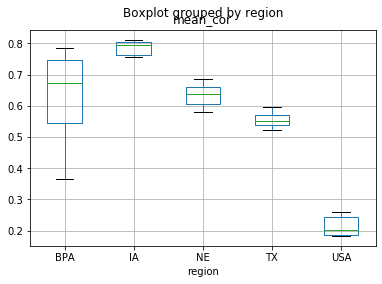

In [259]:
results.boxplot('mean_cor',by='region') # old with wrong BPA wind parks

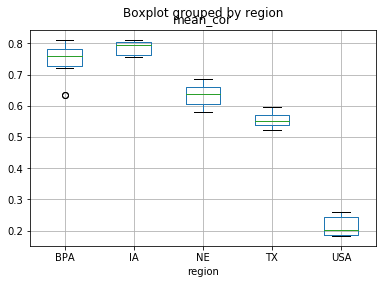

In [65]:
results.boxplot('mean_cor',by='region')

In [66]:
results.to_csv('/data/users/kgruber/results/USA/results_GWA2/correlations_wind_regions.csv')